In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from numpy import exp
import os, time

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [217]:
def getFilesFrom(baseDir):
    files = []
    
    for file in os.listdir(baseDir):
        filePath = os.path.join('files', file)
        files.append(filePath)

    return files


files = getFilesFrom('files')
files

['files\\test_1.csv',
 'files\\test_2.csv',
 'files\\test_3.csv',
 'files\\test_4.csv',
 'files\\test_5.csv',
 'files\\test_6.csv']

# FORMATANDO BLOWING
- Definindo os critérios de "inicio" e "fim" de sopro manualmente, isso foi feito individualmente em cada arquivo usando o critério de derivada para isso, mas a ideia é o modelo servir de modo geral

files\test_3.csv


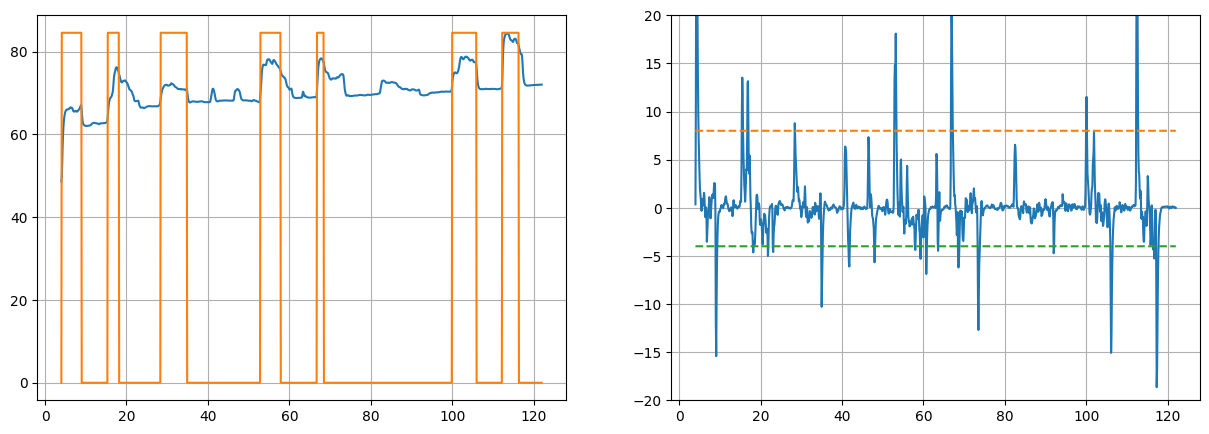

In [218]:
fileNum = 3
path = files[fileNum-1]
df   = pd.read_csv(path)
is_blowing = False

def isBlowing(start, stop):
    global is_blowing

    if start:
        is_blowing = True

    if stop:
        is_blowing = False

    return is_blowing

upper  = 8
lower  = -4

df = df.loc[df.time > 4]
df['start_blow'] = df.derivative > upper
df['stop_blow']  = df.derivative < lower
df['blowing']    = df.apply(lambda row: isBlowing(row.start_blow, row.stop_blow), axis=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.blowing * df.pressure.max())
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.derivative)
plt.plot(df.time, upper*np.ones_like(df.time), '--')
plt.plot(df.time, lower*np.ones_like(df.time), '--')
plt.ylim(-20, 20)
plt.grid()

print(path)
df.to_csv(path, index=None)

# JUNTANDO TABELAS
- Todos os arquivos agora serão juntados em 1 só, para isso, o tempo terá que iniciar (ser somado) partir do último valor do arquivo anterior (para ficar contínuo)

In [219]:
df = pd.DataFrame()

for filePath in files:
    aux = pd.read_csv(filePath)
    aux['time'] = aux.time - aux.time.values[0]
    t0  = 0 if len(df) == 0 else df.time.values[-1]

    print(filePath)
    aux['time'] = aux.time + t0
    df = pd.concat([df, aux])

df

files\test_1.csv
files\test_2.csv
files\test_3.csv
files\test_4.csv
files\test_5.csv
files\test_6.csv


,time,pressure,derivative,blowing,start_blow,stop_blow
0,0.0,84.31757,0.376968,False,False,False
1,0.1,84.34576,0.281906,False,False,False
2,0.2,84.36880,0.230408,False,False,False
3,0.3,84.40068,0.318832,False,False,False
4,0.4,84.44157,0.408936,False,False,False
...,...,...,...,...,...,...
1117,635.5,42.65785,-0.087547,False,False,False
1118,635.6,42.64509,-0.127563,False,False,False
1119,635.7,42.63207,-0.130196,False,False,False
1120,635.8,42.62390,-0.081749,False,False,False


# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

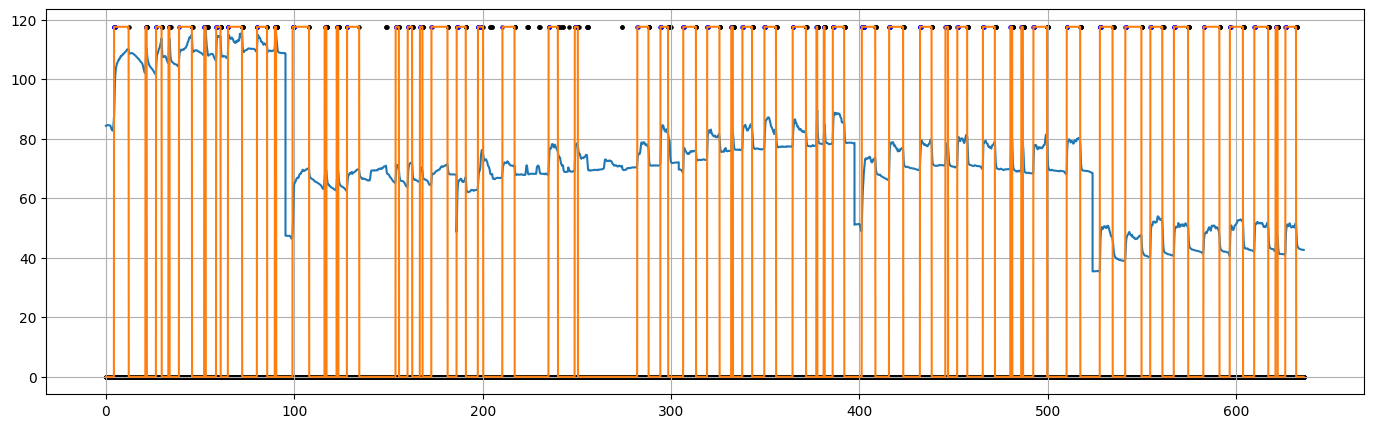

In [220]:
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.plot(df.time,    df.blowing    * df.pressure.max())
plt.scatter(df.time, df.start_blow * df.pressure.max(), s=5, color='blue')
plt.scatter(df.time, df.stop_blow  * df.pressure.max(), s=5, color='black')
plt.grid()

# MODELO
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [221]:
def getStates(df, key, var='y', n=10):
    df[f'{var}n'] = df[key]

    for i in range(1, n):
        df[f'{var}n{i}'] = df[key].shift(i)

    df.fillna(0, inplace=True)
    columns = [f'{var}n'] + [f'{var}n{i}' for i in range(1, n)]
    return df[columns]


def getModel(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=0.15)
    model = LogisticRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = accuracy_score(yTeste, yModel) 
    return model, score


def getModelInfo(model, show=False):
    coefs = list(model.coef_[0])
    intercept = float(model.intercept_[0])
    variables = list(model.feature_names_in_)
        
    if not show:
        return coefs, intercept, variables
    
    text = f'(1.0 / (1.0 + exp(-({intercept:.6f}'

    for i, column in enumerate(variables):
        text += f' + {column}*({coefs[i]:6f})'
    
    return text + '))))'
    

def getBestModel(xData, yData, timeout=5):
    model = getModel(xData, yData)
    bestModel = [0, 0]
    startTime = time.time()
    i = 0

    while time.time() - startTime < timeout:
        model, score = getModel(xData, yData)
        
        if score > bestModel[1]:
            bestModel = model, score
            print('melhor score: ', score)

        if score == 1.0:
            break

        i = i + 1
    
    print('número de iterações', i)
    return bestModel

In [222]:
n = 5
xData = pd.concat([getStates(df, 'pressure', 'P', n), getStates(df, 'derivative', 'D', n)], axis=1)
xData.head(10)

,Pn,Pn1,Pn2,Pn3,Pn4,Dn,Dn1,Dn2,Dn3,Dn4
0,84.31757,0.00000,0.00000,0.00000,0.00000,0.376968,0.000000,0.000000,0.000000,0.000000
1,84.34576,84.31757,0.00000,0.00000,0.00000,0.281906,0.376968,0.000000,0.000000,0.000000
2,84.36880,84.34576,84.31757,0.00000,0.00000,0.230408,0.281906,0.376968,0.000000,0.000000
3,84.40068,84.36880,84.34576,84.31757,0.00000,0.318832,0.230408,0.281906,0.376968,0.000000
4,84.44157,84.40068,84.36880,84.34576,84.31757,0.408936,0.318832,0.230408,0.281906,0.376968
5,84.49172,84.44157,84.40068,84.36880,84.34576,0.501480,0.408936,0.318832,0.230408,0.281906
6,84.53722,84.49172,84.44157,84.40068,84.36880,0.455017,0.501480,0.408936,0.318832,0.230408
7,84.56472,84.53722,84.49172,84.44157,84.40068,0.274963,0.455017,0.501480,0.408936,0.318832
8,84.57603,84.56472,84.53722,84.49172,84.44157,0.113068,0.274963,0.455017,0.501480,0.408936
9,84.58015,84.57603,84.56472,84.53722,84.49172,0.041199,0.113068,0.274963,0.455017,0.501480


# START BLOWING

In [223]:
yData = df.start_blow.values

In [224]:
model, score = getBestModel(xData, yData, timeout=200)
model, score

melhor score:  0.9989528795811519
melhor score:  1.0
número de iterações 10


(LogisticRegression(), 1.0)

In [225]:
df['start_blow_pred'] = model.predict(xData)
blowingModel = model

acuracy: 99.9%


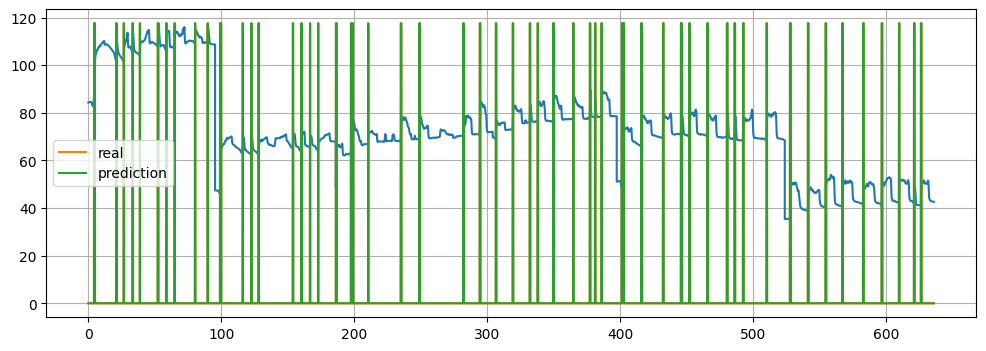

In [226]:
accuracy = (df.start_blow == df.start_blow_pred).sum() / len(df)
print(f'acuracy: {accuracy*100:.1f}%')

plt.figure(figsize=(12, 4))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.start_blow      * df.pressure.max(), label='real')
plt.plot(df.time, df.start_blow_pred * df.pressure.max(), label='prediction')
plt.legend()
plt.grid()

# STOP BLOWING

In [227]:
yData = df.stop_blow.values

In [228]:
model, score = getBestModel(xData, yData, timeout=200)
model, score

melhor score:  0.9947643979057592
melhor score:  0.9968586387434555
melhor score:  0.9989528795811519
melhor score:  1.0
número de iterações 562


(LogisticRegression(), 1.0)

In [229]:
df['stop_blow_pred'] = model.predict(xData)
notBlowingModel = model

acuracy: 99.5%


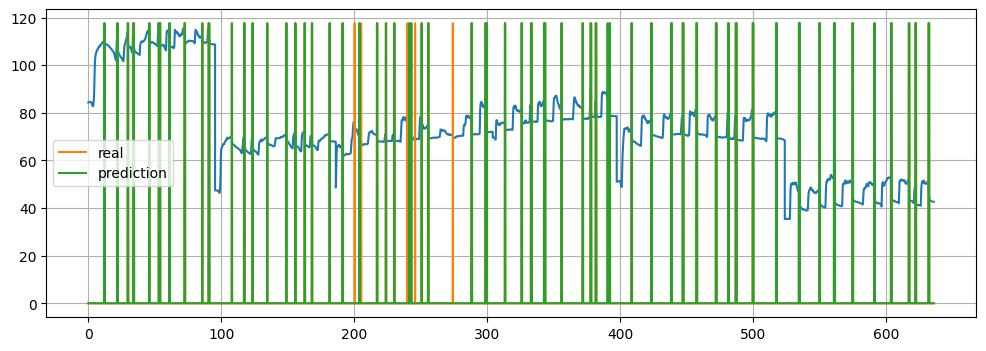

In [230]:
accuracy = (df.stop_blow == df.stop_blow_pred).sum() / len(df)
print(f'acuracy: {accuracy*100:.1f}%')

plt.figure(figsize=(12, 4))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.stop_blow      * df.pressure.max(), label='real')
plt.plot(df.time, df.stop_blow_pred * df.pressure.max(), label='prediction')
plt.legend()
plt.grid()

# JUNTANDO
Usando o modelo para prever o estado de sopro a partir dos status de "inicio" e "fim" preditados pelo modelo

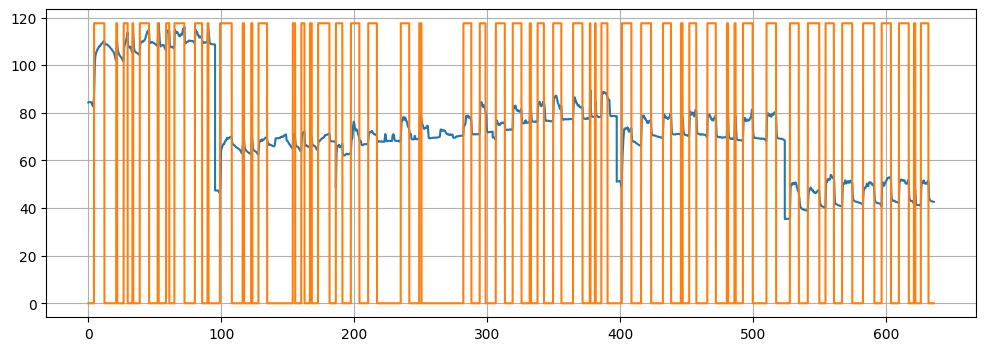

In [231]:
is_blowing = False

def isBlowing(start, end):
    global is_blowing

    if start and not end:
        is_blowing = True

    if end and not start:
        is_blowing = False

    return is_blowing


df['start_blow_pred'] = blowingModel.predict(xData)
df['stop_blow_pred']  = notBlowingModel.predict(xData)
df['prediction'] = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)

plt.figure(figsize=(12, 4))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.prediction * df.pressure.max())
plt.grid()

# IMPLEMENTANDO O MODELO
Para implementar digitalmente em um arduino, o modelo LogisticRegression obedece a seguinte fórmula:
$$p = \frac{1}{1 + e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ....)}}$$

In [232]:
blowString = getModelInfo(blowingModel, show='python')
print(blowString + ';')

(1.0 / (1.0 + exp(-(-14.325869 + Pn*(-0.113933) + Pn1*(0.040068) + Pn2*(0.110146) + Pn3*(-0.076984) + Pn4*(-0.098689) + Dn*(2.778087) + Dn1*(0.101357) + Dn2*(-0.024532) + Dn3*(0.042669) + Dn4*(0.000663)))));


In [233]:
nBlowString = getModelInfo(notBlowingModel, show='python')
print(nBlowString + ';')

(1.0 / (1.0 + exp(-(-12.427494 + Pn*(0.039625) + Pn1*(-0.132618) + Pn2*(-0.099315) + Pn3*(0.270142) + Pn4*(-0.086505) + Dn*(-2.740667) + Dn1*(0.023466) + Dn2*(-0.163954) + Dn3*(0.253341) + Dn4*(-0.083022)))));


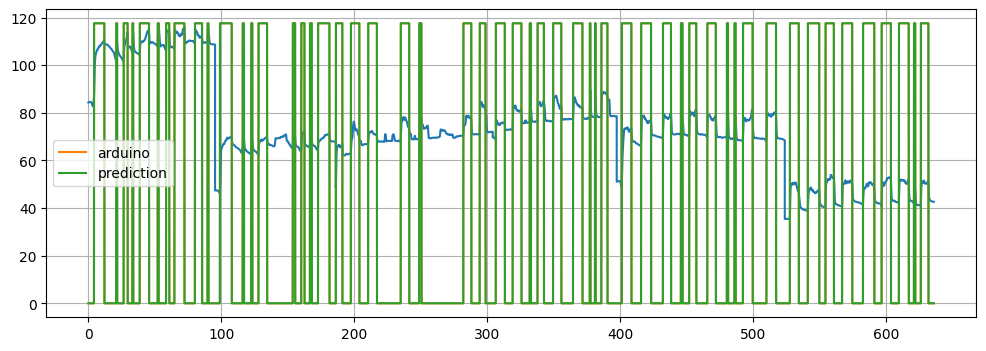

In [234]:
Pn1 = Pn2 = Pn3 = Pn4 = 0
Dn1 = Dn2 = Dn3 = Dn4 = 0
is_blowing = False

def isBlowing(pressure, derivative):
    global Pn1, Pn2, Pn3, Pn4
    global Dn1, Dn2, Dn3, Dn4
    global is_blowing
    Pn = pressure
    Dn = derivative

    pBlow    = eval(blowString)
    pNotBlow = eval(nBlowString)
    
    if pBlow > 0.5:
        is_blowing = True

    if pNotBlow > 0.5:
        is_blowing = False

    Pn4, Pn3, Pn2, Pn1 = Pn3, Pn2, Pn1, Pn
    Dn4, Dn3, Dn2, Dn1 = Dn3, Dn2, Dn1, Dn
    return is_blowing


df['arduino'] = df.apply(lambda row: isBlowing(row.pressure, row.derivative), axis=1)
plt.figure(figsize=(12, 4))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.arduino    * df.pressure.max(), label='arduino')
plt.plot(df.time, df.prediction * df.pressure.max(), label='prediction')
plt.legend()
plt.grid()

# AVALIAÇÃO GERAL

files\test_1.csv


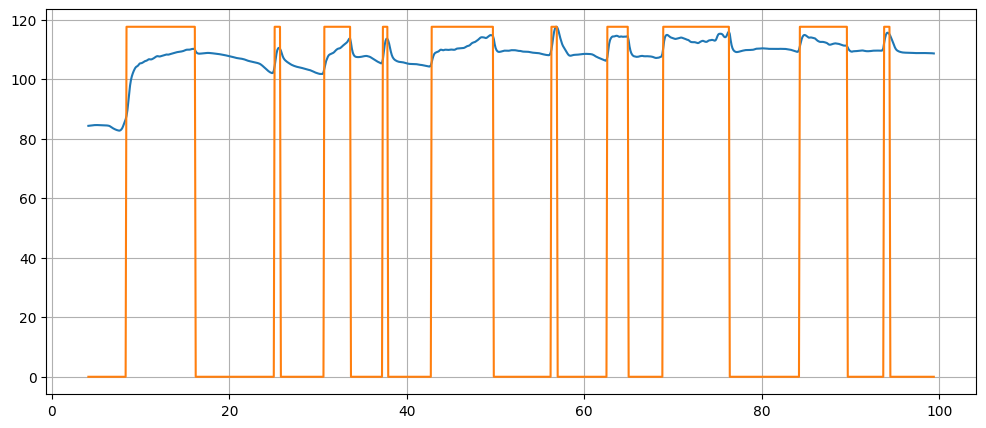

files\test_2.csv


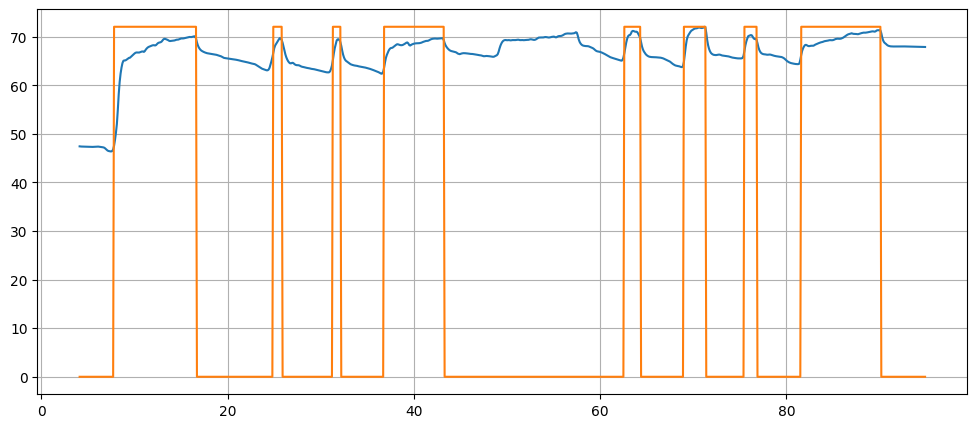

files\test_3.csv


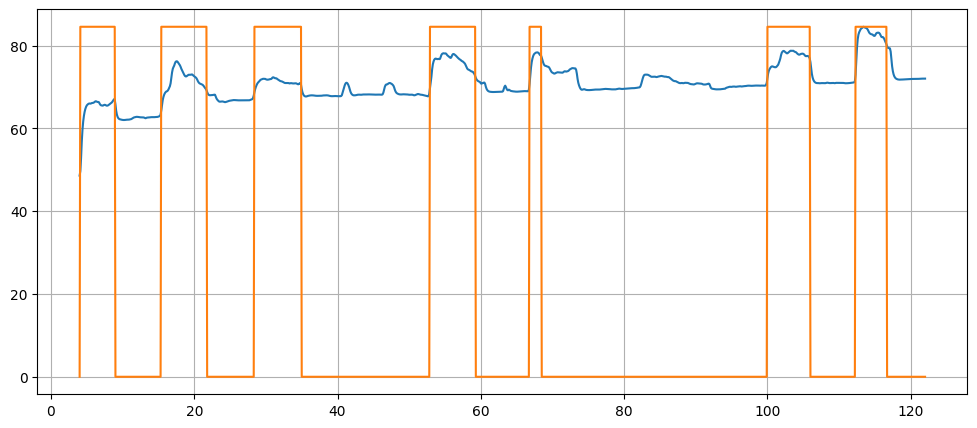

files\test_4.csv


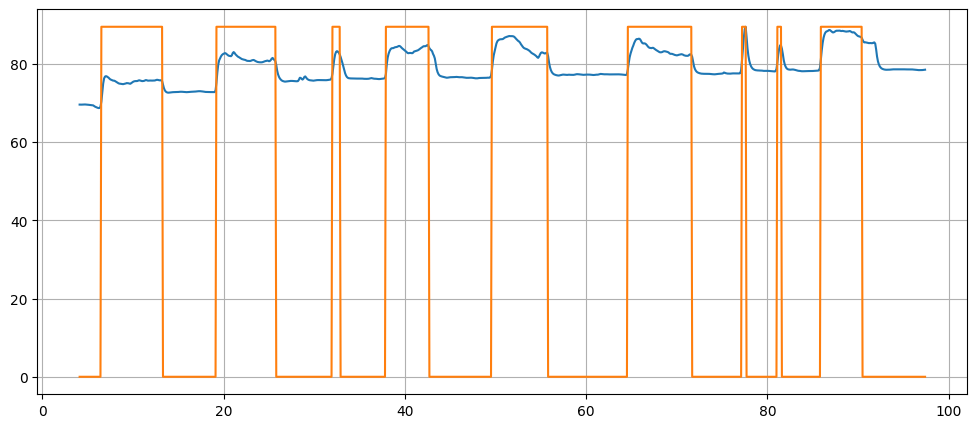

files\test_5.csv


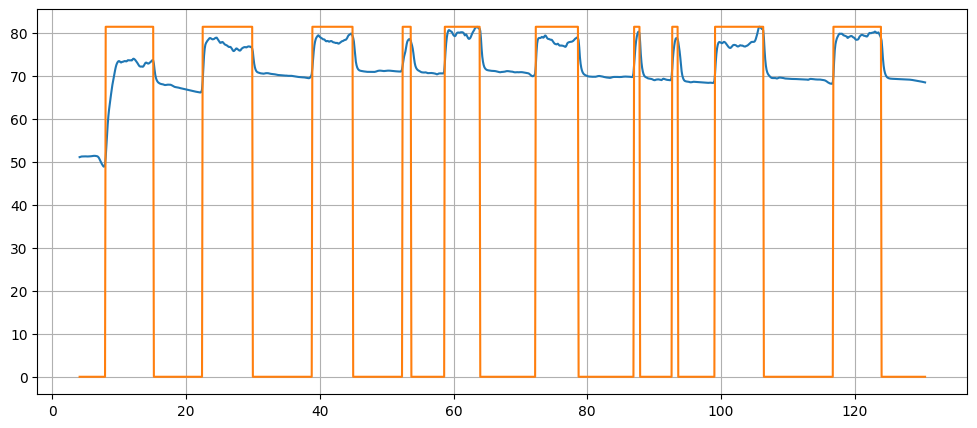

files\test_6.csv


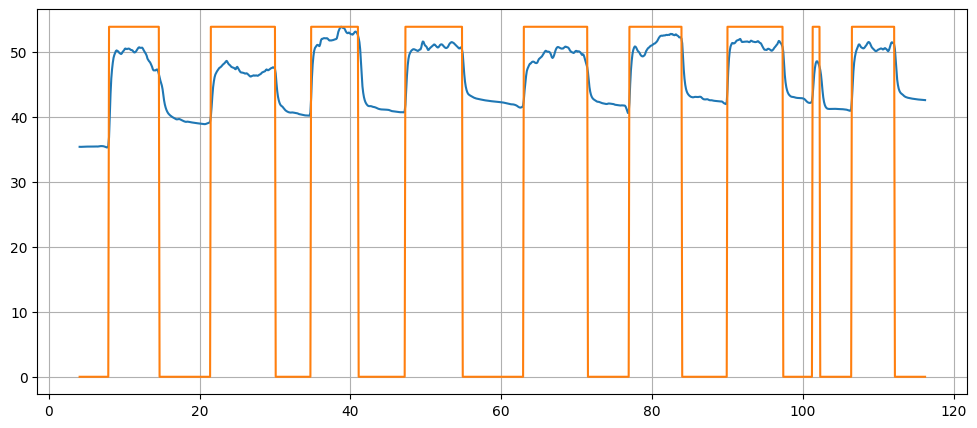

In [235]:
for filePath in getFilesFrom('files'):
    df = pd.read_csv(filePath)
    is_blowing = False
    df['blowing'] = df.apply(lambda row: isBlowing(row.pressure, row.derivative), axis=1)
    
    plt.figure(figsize=(12, 5))
    print(filePath)
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure))
    plt.grid()
    plt.show()